# Assignment 1: Prediction of Airline passengers

**Learning Team 3**
- Francis Mark M. Cayco
- Eros Paul V. Estante
- Andrel Heber M. Jison
- Angela Elaine F. Pelayo

**Masters of Science in Data Science**

COSCI222_0 - Machine Learning 2 


Consider the international airline passengers data from January 1949 to December 1960 here: https://www.kaggle.com/datasets/andreazzini/international-airline-passengers


(1) Forecast using ARIMA the last twelve months (1 year, January-December 1960) with the most optimal choice of p,d,q [10 pts]

(2) Compare the results' RMSE, MAE, and run time with optimal XGBoost. [10 pts]



In [214]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.metrics import mean_absolute_error
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.stattools import adfuller

## Statistics

In [201]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(original_series, diff_series, interval=1):
    original_series = original_series.to_list()
    diff_series = diff_series.copy()
    inverted_series = []
    for i in range(len(diff_series)):
        value = diff_series[i] + original_series[i - interval] 
        inverted_series.append(value)
    return pd.Series(inverted_series)


In [196]:
df = pd.read_csv('assets/international-airline-passengers.csv')
df.columns = ['Date','Passengers']

df['Passengers_Diff'] = pd.Series(difference(df['Passengers'], 12))

df.dropna(subset='Passengers',axis=0, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df_train = df[df['Date'] < '1960-01-01']
df_test = df[df['Date'] >= '1960-01-01']

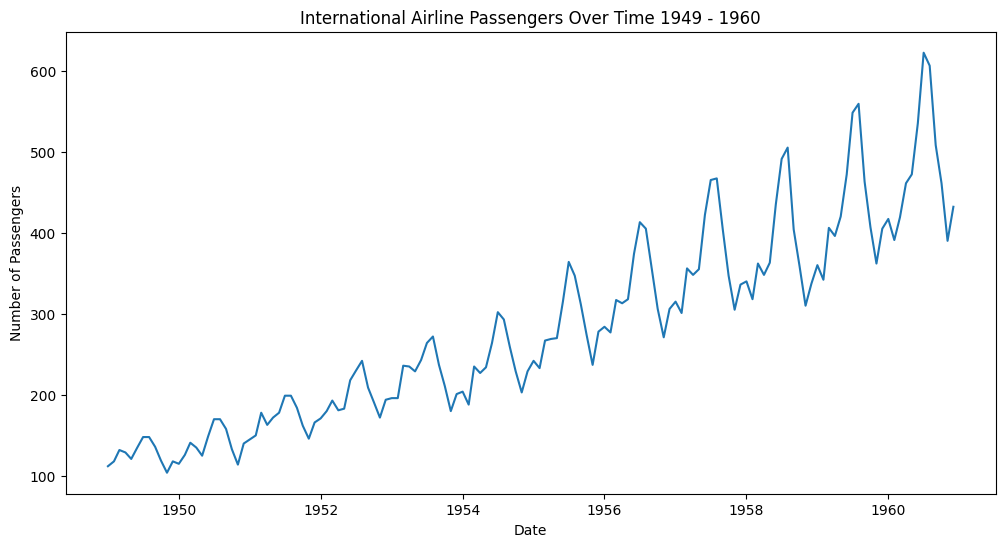

In [199]:
# Plot the data with Date on the x-axis and Passengers on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Passengers'])
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('International Airline Passengers Over Time 1949 - 1960')
plt.show()

Observations:

1. Trend - Shows an upward trend over time, indicating that the number of airline passengers has been increasing steadily.
2. Seasonality - repeating seasonal pattern, with peaks and troughs occurring at yearly intervals.
3. Stationarity - The data is non-stationary, as the mean and variance change over time.

### Seasonal Line Plot

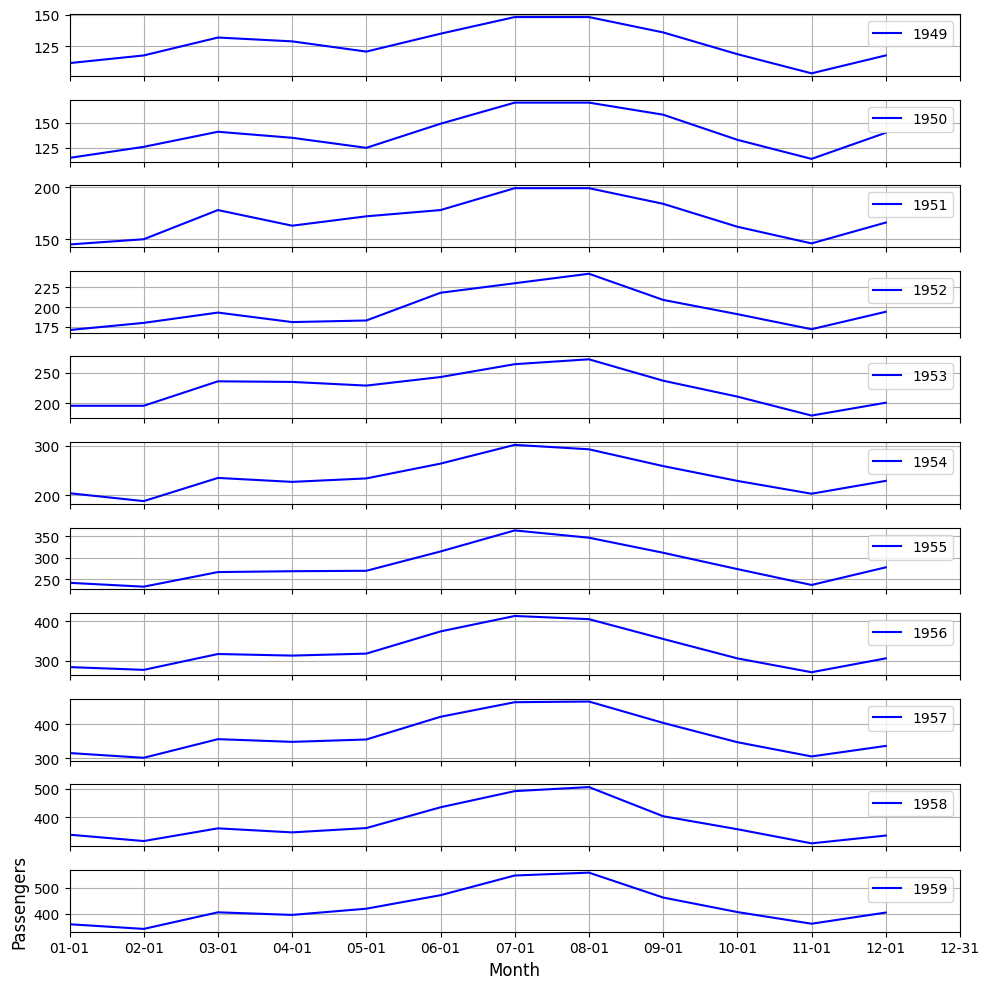

In [200]:
# Set the 'Date' column as index
df_train.set_index('Date', inplace=True)

# Group the training data by year ('A' stands for annual frequency)
groups = df_train.groupby(pd.Grouper(freq='YE'))

# Initialize the plotting area, making sure to accommodate each group
fig, axs = plt.subplots(len(groups), 1, figsize=(10, 10), sharex=True)

# Loop over each group to plot separately
for i, (name, group) in enumerate(groups):
    # Format index to show only the month and day for alignment
    group.index = group.index.strftime('%m-%d')
    
    axs[i].plot(group.index, group['Passengers'], label=f'{name.year}', color='b')
    axs[i].set_xlim(['01-01', '12-31'])  # Set x-axis from January to December
    axs[i].legend(loc='upper right')  # Use the legend to show the year
    axs[i].grid(True)  # Add grid for better visual clarity

# Set common x and y labels
plt.xlabel('Month', fontsize=12)
plt.ylabel('Passengers', fontsize=12)

# Adjust layout to prevent overlap and ensure clarity
plt.tight_layout()

# Show the plot
plt.show()

Observation

- Seasonality: Similar pattern is observed where peaks usually happens in July & August, and troughs happening in November, and February


- Year-to-Year Consistency: This pattern appears similarly almost every year. While the absolute number of passengers increases over the years, the relative seasonal behavior remains steady, reinforcing the reliability of this pattern for forecasting.

### Density Plot

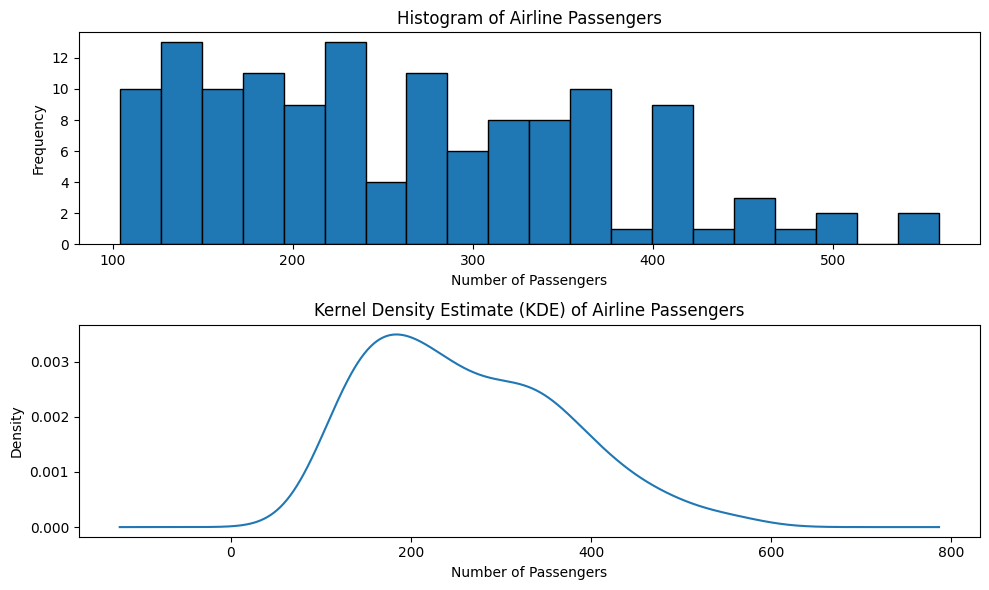

In [202]:
import matplotlib.pyplot as plt

# Extract the 'Passengers' column from the training dataset
series = df_train['Passengers']

# Create the figure for subplots with appropriate size
plt.figure(figsize=(10, 6))

# Create the histogram in the first subplot
plt.subplot(2, 1, 1)
plt.hist(series, bins=20, edgecolor='black')
plt.title('Histogram of Airline Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Frequency')

# Create the kernel density estimate (KDE) plot in the second subplot
plt.subplot(2, 1, 2)
series.plot(kind='kde')
plt.title('Kernel Density Estimate (KDE) of Airline Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Observations 

1. Non-Gaussian Distribution - The histogram shows a skewed shape rather than a symmetric bell curve
2. Distribution Shape - The distribution of airline passengers is right-skewed, meaning that most observations are on the lower side with a long tail extending to the right.

### Box and Whisker Plot

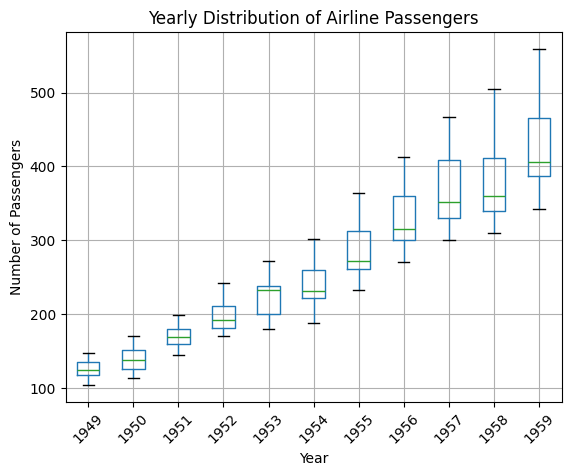

In [203]:
import pandas as pd
import matplotlib.pyplot as plt

series = df_train['Passengers']

# Group the series data by year ('A' stands for annual frequency)
groups = series['1949':'1959'].groupby(pd.Grouper(freq='YE'))

# Create an empty DataFrame to store yearly data
years = pd.DataFrame()

# Loop through each group and store the values in the 'years' DataFrame
for name, group in groups:
    years[name.year] = group.values

# Plot a boxplot for each year
years.boxplot()

# Show the plot
plt.title('Yearly Distribution of Airline Passengers')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Observations

1. Median (Green Line) - increases steadily over time. This indicates consistent growth of passengers over time.
2. Spread (Blue Boxes) - size of boxes increases over time, indicating increasing variability - higher flunctuations over time. 
3. Outliers - no significant outliers, indicating stable and reliable data trends.

### Overall Observations

- Trend: Passenger numbers show a consistent upward trajectory from 1949 to 1959, indicating a strong long-term growth component.
- Seasonality: Clear annual patterns with recurring peaks suggest the presence of seasonal trends, making seasonal adjustments crucial.
- Variability: The increasing spread in passenger numbers over time highlights growing fluctuations that ARIMA models need to accommodate.
- Stationarity Consideration: The upward trend and seasonal effects suggest the need for differencing to achieve stationarity before modeling.


## Stationary Test for Seasonal Lag Differencing

## Hypotheses in the ADF Test

### Null Hypothesis $  H_0 \ $

- The time series **has a unit root**, meaning it is **non-stationary**, i.e., it has some time-dependent structure.
- If the null hypothesis cannot be rejected, the series is likely **non-stationary**.

### Alternative Hypothesis $  H_1  $

- The time series **does not have a unit root**, meaning it is **stationary**.

## Interpreting the ADF Test Results

### If the p-value > 0.05:
- **Fail to reject the null hypothesis  $ H_0 $ .**
- The series is **non-stationary**, meaning further differencing or transformations may be needed.

### If the p-value ≤ 0.05:
- **Reject the null hypothesis $ H_0 $ in favor of the alternative $ H_1 $.**
- The series is **stationary**, meaning no further differencing is needed.


In [206]:
# Perform the ADF test to check stationarity
# Ensure df['Passengers'] is converted to a list or numpy array for indexing
stationary_series = difference(df['Passengers'].values, 12)

# Perform the ADF test
result = adfuller(stationary_series)

# Print the ADF test results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -3.383021
p-value: 0.011551
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


- Since the p-value (0.011551) is less than 0.05, we reject the null hypothesis meaning that the time series is stationary after applying seasonal differencing with a lag of 12 months.

- Additionally, the ADF statistic (-3.383021) is lower (more negative) than the 5% critical value (-2.884), further supporting the conclusion that the series does not contain a unit root and is stationary.


## Forecasting Using ARIMA

In [252]:
p_values = range(0, 8)
d_values = range(0, 2)
q_values = range(0, 8)

In [ ]:
model = []
rmse = []
forecasts = []
times = []
mse = []
for p, d, q, in product(p_values, d_values, q_values):
    time_ = time.time()
    arima = ARIMA(df_train['Passengers_Diff'], order=(p,d,q), enforce_stationarity=True, dates=df_train.index)
    arima_fit = arima.fit()
    forecast = arima_fit.get_forecast(steps=len(df_test))
    forecast_values = forecast.predicted_mean.values
    forecast_values = inverse_difference(df_train['Passengers'],forecast_values,len(df_test))
    # display(test)
    forecasts.append(forecast_values)
    model.append((p, d, q))
    rmse.append(root_mean_squared_error(df_test['Passengers'], forecast_values))
    mse.append(mean_squared_error(df_test['Passengers'], forecast_values))
    times.append(time.time() - time_)


/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/msds_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No fr

In [258]:
results = pd.DataFrame({'ARIMA(p,d,q)': model, 'RMSE': rmse, 'Time': times, 'MSE':mse}).sort_values('RMSE')
results.head(10)

,"ARIMA(p,d,q)",RMSE,Time,MSE
46,"(2, 1, 6)",19.152230,0.141345,366.807920
45,"(2, 1, 5)",19.400993,0.099878,376.398537
63,"(3, 1, 7)",20.572509,0.202708,423.228115
12,"(0, 1, 4)",20.869945,0.016020,435.554603
79,"(4, 1, 7)",21.323730,0.226072,454.701465
122,"(7, 1, 2)",21.347450,0.129034,455.713638
15,"(0, 1, 7)",21.405850,0.064843,458.210420
62,"(3, 1, 6)",21.469318,0.164227,460.931613
14,"(0, 1, 6)",21.502120,0.039453,462.341152
29,"(1, 1, 5)",21.602356,0.066283,466.661774


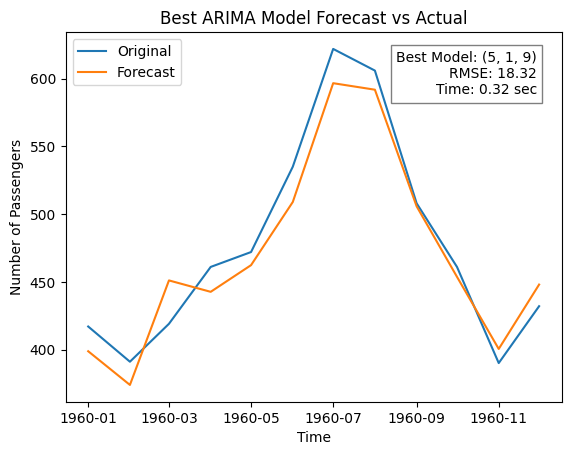

In [246]:
best_model = model[np.argmin(rmse)]
best_rmse = np.min(rmse)

plt.plot(df_test['Date'], df_test['Passengers'], label='Original')
plt.plot(df_test['Date'], forecasts[np.argmin(rmse)], label='Forecast')
plt.title('Best ARIMA Model Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.text(0.95, 0.95, f'Best Model: {best_model}\nRMSE: {best_rmse:.2f}\nTime: {times[np.argmin(rmse)]:.2f} sec', 
         horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5))

plt.show()


## Forecasting using XGBoost

In [32]:
# Enter code Here

## Interpretation of the results
TODO: Also include Comparison of the results of ARIMA and XGBoost